In [66]:
%pip install prince

Note: you may need to restart the kernel to use updated packages.


In [76]:
import re, io, os
import urllib.request
from collections import defaultdict
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from prince import MCA

In [7]:
def tokenize(data):
	index = defaultdict(str)

	with open(data) as file:
		for line in file.read().splitlines():
			# pull out takahashi lines
			m = re.match(r'^<(f.*?)\..*;H> +(\S.*)$', line)
			if not m:
				continue

			transcription = m.group(2)
			pg = str(m.group(1))

			# ignore entire line if it has a {&NNN} or {&.} code
			if re.search(r'\{&(\d|\.)+\}', transcription):
				continue

			# remove extraneous chracters ! and %
			s = transcription.replace("!", "").replace("%", "")

			# delete all end of line {comments} (between one and three observed)
			# ...with optional line terminator
			# allow 0 occurences to remove end-of-line markers (- or =)
			s = re.sub(r'([-=]?\{[^\{\}]+?\}){0,3}[-=]?\s*$', "", s)

			# delete start of line {comments} (single or double)
			s = re.sub(r'^(\{[^\{\}]+?\}){1,2}', "", s)

			# simplification: tags preceeded by -= are word breaks
			s = re.sub(r'[-=]\{[^\{\}]+?\}', '.', s)

			# these tags are nulls
			# plant is a null in one case where it is just {plant}
			# otherwise (above) it is a word break
			# s = re.sub(r'\{(fold|crease|blot|&\w.?|plant)\}', "", s)
			# simplification: remaining tags in curly brackets
			s = re.sub(r'\{[^\{\}]+?\}', '', s)

			# special case .{\} is still a word break
			s = re.sub(r'\.\{\\\}', ".", s)

			# split on word boundaries
			# exclude null words ('')
			words = [str(w) for w in s.split(".") if w]
			paragraph = ' '.join(words).lstrip()

			index[pg] += (paragraph)

	return index

In [28]:
fpath = "/Users/katecastillo/Documents/MSDS/voynich-manuscript/takahashi_transcription.txt"

index = tokenize(fpath)
corpus = [index[key] for key in index.keys()]

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=2)
tfidf_matrix = vectorizer.fit_transform(corpus)
vms_mapping = [k for k in index.keys()]

In [ ]:
# models_path = "models"

# with open("{}/tfidf_vectorizer.pk".format(models_path),"wb") as f: # vectorizers 
#     pickle.dump(tfidf_vectorizer, f)
# with open("{}/tf_vectorizer.pk".format(models_path),"wb") as f:
#     pickle.dump(tf_vectorizer, f)

# with open("{}/vms_tfidf.pk".format(models_path),"wb") as f: # models
#     pickle.dump(vms_tfidf, f)
# with open("{}/vms_tf.pk".format(models_path),"wb") as f:
#     pickle.dump(vms_tf, f)

# with open("{}/vms_mapping.pk".format(models_path), "wb") as f: # mapping
#     pickle.dump(vms_mapping, f)

In [57]:
n_components = 6
nmf_model = NMF(n_components=n_components, random_state=42)
nmf_features = nmf_model.fit_transform(tfidf_matrix)

/Users/katecastillo/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [58]:
words = vectorizer.get_feature_names_out()
for index, topic in enumerate(nmf_model.components_):
    print(f"Topic {index}:")
    print([words[i] for i in topic.argsort()[-10:]])

Topic 0:
['qokal', 'shey', 'qokeey', 'qol', 'ol', 'qokeedy', 'qokain', 'qokedy', 'chedy', 'shedy']
Topic 1:
['cthor', 'shor', 'shy', 'sho', 'chy', 'shol', 'cthy', 'chor', 'chol', 'daiin']
Topic 2:
['qotaiin', 'chedy', 'qokeey', 'okaiin', 'otaiin', 'ar', 'qokeedy', 'al', 'aiin', 'qokaiin']
Topic 3:
['sheol', 'ckhey', 'chol', 'or', 'daiin', 'qokeol', 'cheor', 'cheol', 'ol', 'okeol']
Topic 4:
['ol', 'or aiin', 'qokar', 'dar', 'okar', 'ar', 'chedy', 'chdy', 'aiin', 'or']
Topic 5:
['otey', 'air', 'dar', 'oteody', 'oteey', 'aiin', 'dal', 'oteos', 'ar', 'al']


In [59]:
topic_distribution = pd.DataFrame(nmf_features, columns=[f"Topic {i+1}" for i in range(n_components)], index=vms_mapping)
topic_distribution

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
f1r,0.000000,0.240193,0.000000,0.050071,0.061804,0.039797
f1v,0.000000,0.142624,0.000000,0.105332,0.014035,0.000000
f2r,0.015502,0.169788,0.000000,0.000000,0.000000,0.031498
f2v,0.000000,0.208955,0.000000,0.047633,0.000000,0.000000
f3r,0.000000,0.144002,0.000000,0.134691,0.023631,0.000000
...,...,...,...,...,...,...
f114r,0.000000,0.028796,0.286732,0.022092,0.157699,0.011514
f114v,0.000000,0.024838,0.345465,0.016987,0.048828,0.000000
f115r,0.054167,0.021303,0.322326,0.066719,0.014427,0.020465
f115v,0.046498,0.018960,0.305704,0.000000,0.013559,0.000000


In [60]:
davis_df = pd.read_csv("data/davis_attribution.csv", index_col="folio")
davis_df

,topic,hand,language,quire
folio,,,,
f1r,botanical,1,a,1
f1v,botanical,1,a,1
f2r,botanical,1,a,1
f2v,botanical,1,a,1
f3r,botanical,1,a,1
...,...,...,...,...
f114r,starred paragraphs,3,b,18
f114v,starred paragraphs,3,b,18
f115r,starred paragraphs,3,b,18


In [61]:
dominant_topics = np.argmax(nmf_features, axis=1)
dominant_topics

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 0, 4, 1, 1, 1, 1, 1, 1, 3, 1, 4, 5, 1, 1, 4, 4, 4, 4,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 0, 3, 1, 1, 4, 4, 1, 1, 1, 1,
       4, 4, 1, 1, 4, 4, 1, 1, 4, 4, 3, 3, 1, 1, 1, 1, 3, 3, 4, 4, 1, 1,
       3, 5, 5, 2, 4, 5, 0, 4, 5, 5, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0])

In [78]:
output_df = davis_df.copy()[["language"]]
output_df["topic_nmf"] = dominant_topics

output_df

,language,topic_nmf
folio,,
f1r,a,1
f1v,a,1
f2r,a,1
f2v,a,1
f3r,a,1
...,...,...
f114r,b,2
f114v,b,2
f115r,b,2


In [81]:
mca = MCA(n_components=2, n_iter=4, copy=True, check_input=True, random_state=42)
mca = mca.fit_transform(output_df)

AttributeError: 'DataFrame' object has no attribute 'plot_coordinates'

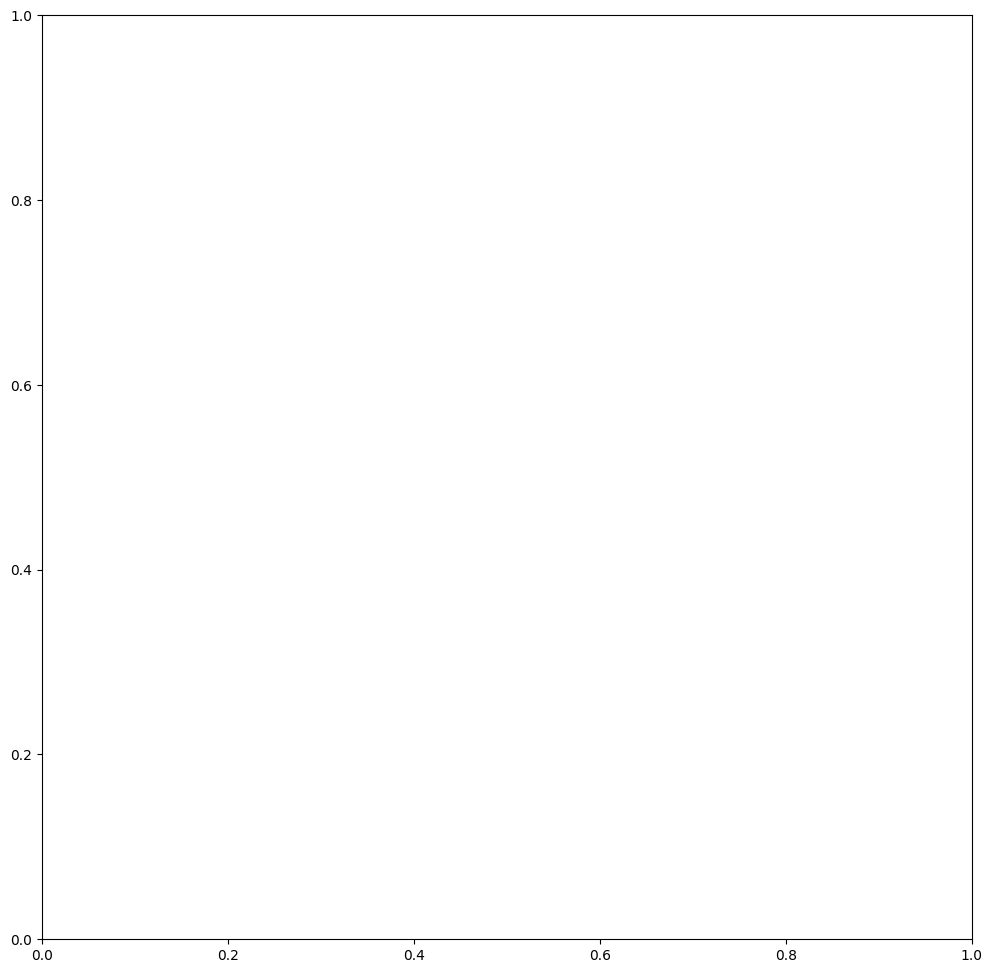

In [82]:


fig, ax = plt.subplots(figsize=(12, 12))

for column in output_df.columns:
    mca.plot_coordinates(
        output_df,
        ax=ax,
        show_column_labels=True,
        column=column,
        show_row_points=True,
        row_points_size=10,
        show_column_points=True,
        column_points_size=30,
        legend_n_cols=2
    )

plt.title('MCA Analysis of Voynich Manuscript Features')
plt.tight_layout()

In [63]:
len(dominant_topics)

225

## Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [43]:
topic_df = topic_df = topic_distribution.join(davis_df)

topic_df["language_encoded"] = LabelEncoder().fit_transform(topic_df["language"])
topic_df["hand_encoded"] = LabelEncoder().fit_transform(topic_df["hand"])
topic_df["illustrative_encoded"] = LabelEncoder().fit_transform(topic_df["topic"])

topic_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,topic,hand,language,quire,language_encoded,hand_encoded,illustrative_encoded
f1r,0.000000,0.023319,0.000000,0.040743,0.060303,0.030825,0.008197,0.216125,0.000000,0.099879,botanical,1,a,1,0,1,2
f1v,0.004104,0.000000,0.000000,0.038898,0.011784,0.000000,0.000000,0.220826,0.051757,0.005560,botanical,1,a,1,0,1,2
f2r,0.003937,0.030010,0.000000,0.000000,0.000000,0.000835,0.010332,0.075315,0.078490,0.108863,botanical,1,a,1,0,1,2
f2v,0.000000,0.000000,0.000000,0.020570,0.000000,0.000000,0.000000,0.295728,0.000000,0.002153,botanical,1,a,1,0,1,2
f3r,0.000000,0.004119,0.000000,0.044532,0.034462,0.000000,0.000000,0.230716,0.057705,0.000000,botanical,1,a,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f114r,0.016115,0.059170,0.231097,0.000000,0.168073,0.009188,0.000000,0.000000,0.070967,0.000000,starred paragraphs,3,b,18,1,3,5
f114v,0.005868,0.057299,0.295695,0.006189,0.081722,0.000000,0.000000,0.000215,0.010999,0.000000,starred paragraphs,3,b,18,1,3,5
f115r,0.011054,0.006095,0.295809,0.003157,0.028221,0.008844,0.064279,0.019125,0.114399,0.005805,starred paragraphs,3,b,18,1,3,5
f115v,0.028954,0.000000,0.281700,0.000000,0.017210,0.000000,0.029180,0.014674,0.057602,0.009728,starred paragraphs,3,b,18,1,3,5


In [46]:
cols = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6',
       'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'language_encoded', 
       'hand_encoded', 'illustrative_encoded']

In [50]:
mca = MCA(n_components=2, random_state=42)
mca_result = mca.fit_transform(topic_df[cols])
mca_result

,0,1
f1r,-0.285522,-0.203818
f1v,-0.217112,-0.140245
f2r,-0.257012,-0.166435
f2v,-0.144218,-0.128541
f3r,-0.170140,-0.154964
...,...,...
f114r,-0.000668,0.329759
f114v,-0.049513,0.482544
f115r,0.630029,12.959457
f115v,-0.076693,0.619047


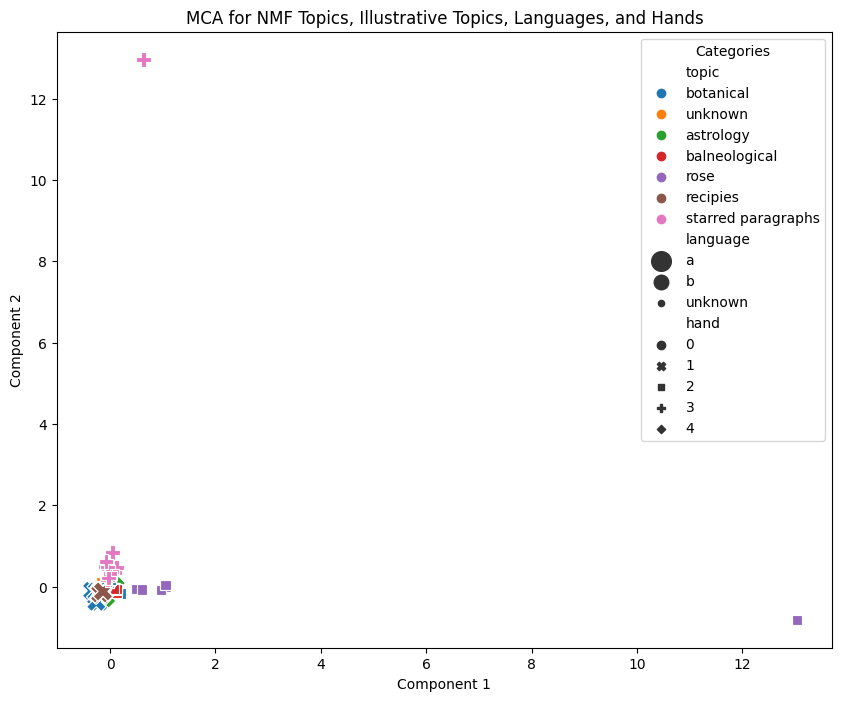

In [ ]:


plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=mca_result[0], y=mca_result[1],
    hue=topic_df["topic"],
    style=topic_df["hand"],
    size=topic_df["language"],
    sizes=(20, 200),
    palette="tab10"
)

plt.title("MCA for NMF Topics, Illustrative Topics, Languages, and Hands")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc="best", title="Categories")
plt.show()